In [122]:
import openmc
import numpy as np
import neutronics_material_maker as nmm
import matplotlib.pyplot as plt
import openmc_source_plotter
import plotly.graph_objects as go
from math import cos, pi, sin

In [103]:
#old code when finding dose

energy_bins_n, dose_coeffs_n = openmc.data.dose_coefficients(
    particle='neutron', geometry='AP')

In [104]:
#materials
#air
air = openmc.Material(name='air')
air.add_element("O",0.210748,'ao')
air.add_element("N",0.784431,'ao')
air.add_element("Ar",0.004671,'ao')
air.add_element("C", 0.00015,'ao')
air.set_density("g/cm3", 0.001205)

#ground surface - concrete
ground_material = openmc.Material(name='ground_material')
ground_material.add_element("H" , 0.0052, 'ao')
ground_material.add_element("O",  0.3273, 'ao')
ground_material.add_element("C", 0.004, 'ao')
ground_material.add_element("Si", 0.0224, 'ao')
ground_material.add_element("Ca",  0.0657, 'ao')
ground_material.add_element("Mg", 0.0021, 'ao')
ground_material.add_element("Al", 0.0038, 'ao')
ground_material.add_element("Fe", 0.568, 'ao')
ground_material.add_element("P", 0.0015, 'ao')
ground_material.set_density("g/cm3", 3.6)

mats = openmc.Materials([ground_material, air])
mats.export_to_xml()

In [105]:
x_coeff = 1
y_coeff = 15

#air region with reflective bound for symmetry
air_down_diag = openmc.Plane(a=x_coeff, b=y_coeff, boundary_type='reflective')
air_up_diag = openmc.Plane(a=x_coeff, b=-y_coeff, boundary_type='reflective')
air_top = openmc.ZPlane(z0=100000)
air_bottom = openmc.ZPlane(z0=0)
r_wall = openmc.XPlane(x0=50000, boundary_type='vacuum')
l_wall = openmc.XPlane(x0=0)

#ground geometry
ground_down_diag = openmc.Plane(a=x_coeff, b=y_coeff, boundary_type='reflective')
ground_up_diag = openmc.Plane(a=x_coeff, b=-y_coeff, boundary_type='reflective')
ground_top = openmc.ZPlane(z0=0)
ground_bottom = openmc.ZPlane(z0=-100)

air_region= +air_bottom & -air_top & +air_down_diag & +air_up_diag & -r_wall & +l_wall
air_cell = openmc.Cell(fill=air, region=air_region)

ground_region= +ground_bottom & -ground_top & +air_up_diag & +air_down_diag & -r_wall & +l_wall
ground_cell = openmc.Cell(fill=ground_material, region=ground_region)


In [106]:
#void
ll = [-10, -6010, -1001]
ur = [50010, 6010, 100010]
xmin = openmc.XPlane(x0=ll[0], boundary_type = 'vacuum')
xmax = openmc.XPlane(x0=ur[0], boundary_type = 'vacuum')
ymin = openmc.YPlane(y0=ll[1], boundary_type = 'vacuum')
ymax = openmc.YPlane(y0=ur[1], boundary_type = 'vacuum')
zmin = openmc.ZPlane(z0=ll[2], boundary_type = 'vacuum')
zmax = openmc.ZPlane(z0=ur[2], boundary_type = 'vacuum')

whole_region = +xmin & -xmax & -ymax & +ymin & -zmax & +zmin
void = whole_region  &~air_region & ~ground_region
void_cell =  openmc.Cell(region=void)

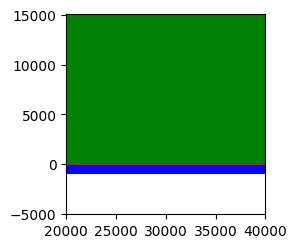

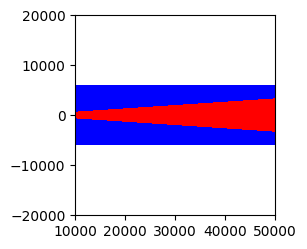

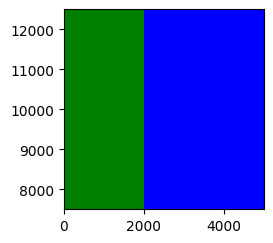

In [107]:
universe = openmc.Universe(cells=[void_cell, air_cell, ground_cell])
geom = openmc.Geometry(universe)
geom.export_to_xml()

color_assignment = {void_cell: 'blue', ground_cell: 'red', air_cell:'green'}
plt.show(universe.plot(origin=(30000,0,5000), width=(20000, 20100), basis='xz', colors=color_assignment))
plt.show(universe.plot(origin=(30000,0,0), width=(40000,40000), basis='xy', colors=color_assignment))
plt.show(universe.plot(origin=(30000,2500,10000), width=(5000,5000), basis='yz', colors=color_assignment))

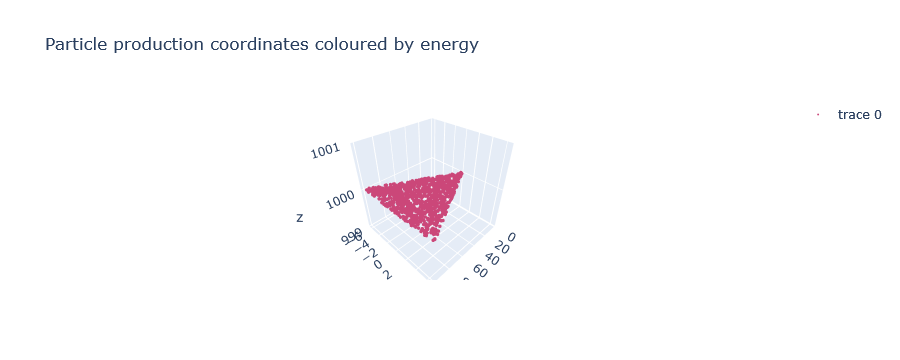

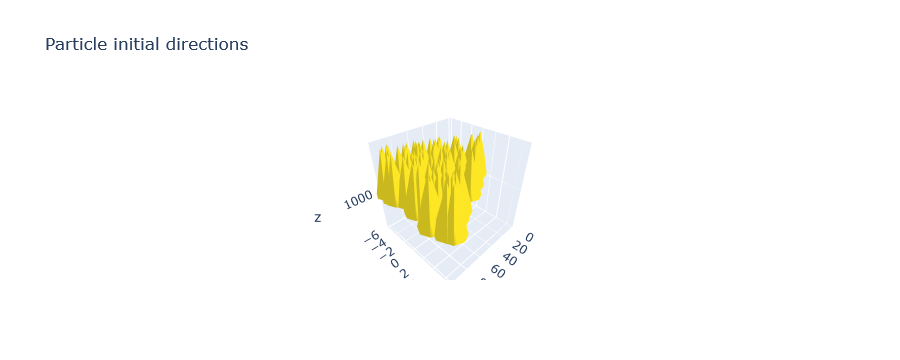

In [125]:
# initialises a new source object
ring_source = openmc.Source()

# the distribution of radius is between two points and is uniform 
radius = openmc.stats.PowerLaw(0.001, 100, 1)

# the distribution of source z values is just a single value
z_values = openmc.stats.Discrete([1000], [1])

# the distribution of source azimuthal angles values is a uniform distribution between 0 and 2 Pi
gradient = (1/y_coeff) / (1/x_coeff)
angle = openmc.stats.Uniform(a=-np.arctan(gradient), b=np.arctan(gradient))

# this makes the ring source using the three distributions and a radius
ring_source.space = openmc.stats.CylindricalIndependent(r=radius, phi=angle, z=z_values, origin=(0.0, 0.0, 000.0))

# sets the direction to upwards direction
ring_source.angle =  openmc.stats.Monodirectional([0,0,1])

# sets the energy distribution to a discrete 19MeV energy
ring_source.energy = openmc.stats.Discrete([19e6], [1])

%matplotlib inline
plot1 = ring_source.plot_source_position(n_samples=1000)
plot1.show()
%matplotlib inline
plot2 = ring_source.plot_source_direction(n_samples=100)
plot2.show()


In [109]:
#create the source
sett = openmc.Settings()
sett.particles = 1000000
sett.batches = 5
sett.inactive = 0
sett.run_mode = 'fixed source'
sett.source = ring_source
sett.export_to_xml()

In [110]:
#mesh
mesh_ll = [0, -6000, 0]
mesh_ur = [50000, 6000, 100]
mesh_size = 1000
air_mesh = openmc.RegularMesh(mesh_id=1, name="air_mesh")
air_mesh.dimension = [mesh_size,1,1]
air_mesh.lower_left = mesh_ll
air_mesh.upper_right = mesh_ur

mesh_filter = openmc.MeshFilter(air_mesh)
#air_mesh.vertices

/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning:

Another MeshBase instance already exists with id=1.



In [111]:
#tally
neutron_particle_filter = openmc.ParticleFilter(['neutron'])
tallies = openmc.Tallies()
flux_tally = openmc.Tally(name='flux_tally')
flux_tally.scores  = ['flux']
flux_tally.filters = [mesh_filter, neutron_particle_filter]
tallies.append(flux_tally)
tallies.export_to_xml()

In [112]:
#look at current through mesh surface
energy_function_filter_n = openmc.EnergyFunctionFilter(energy_bins_n, dose_coeffs_n)
surf_mesh_filter = openmc.MeshSurfaceFilter(air_mesh)
current_tally = openmc.Tally(name='current_tally')

current_tally.scores = ['current']
current_tally.filters = [ surf_mesh_filter, neutron_particle_filter]
tallies.append(current_tally)

In [113]:

model = openmc.model.Model(geom, mats, sett, tallies)
!rm *.h5
results_filename = model.run()
    
results = openmc.StatePoint(results_filename)
flux_tally = results.get_tally(name="flux_tally")
current_tally = results.get_tally(name="current_tally")

results.close()
df_dose = flux_tally.get_pandas_dataframe()
df_curr = current_tally.get_pandas_dataframe()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

In [114]:
mesh_x = (mesh_ur[0] - mesh_ll[0]) / mesh_size
mesh_y = (mesh_ur[1] - mesh_ll[1])
mesh_z = (mesh_ur[2] - mesh_ll[2])
mesh_vol = mesh_x * mesh_y * mesh_z
distance_x = air_mesh.vertices[:,0,0,0]
mesh_vol

60000000.0

In [115]:
df_dose

mesh 1       particle nuclide score     mean std. dev.
         x  y  z                                          
0        1  1  1  neutron   total  flux 2.83e-03  2.65e-04
1        2  1  1  neutron   total  flux 9.22e-03  5.90e-04
2        3  1  1  neutron   total  flux 1.62e-02  4.58e-04
3        4  1  1  neutron   total  flux 2.21e-02  5.55e-04
4        5  1  1  neutron   total  flux 2.86e-02  1.01e-03
..     ... .. ..      ...     ...   ...      ...       ...
995    996  1  1  neutron   total  flux 3.00e-02  9.05e-04
996    997  1  1  neutron   total  flux 2.78e-02  9.54e-04
997    998  1  1  neutron   total  flux 2.74e-02  9.94e-04
998    999  1  1  neutron   total  flux 2.57e-02  7.84e-04
999   1000  1  1  neutron   total  flux 2.35e-02  1.13e-03

[1000 rows x 8 columns]

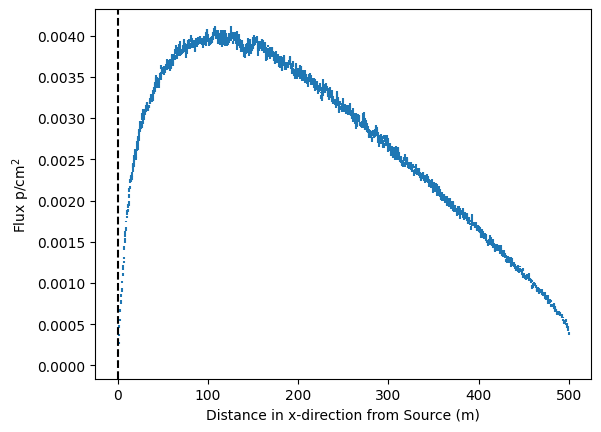

In [124]:

flux = df_dose[df_dose['score'] == 'flux']
flux_mean = (flux["mean"] /mesh_vol)
flux_std = (flux["std. dev."] /mesh_vol) 
plt.errorbar(distance_x[:-1]/100, flux_mean*1e6, flux_std*1e6, ls='None')
plt.xlabel("Distance in x-direction from Source (m)")
plt.ylabel("Flux p/cm$^2$ ")
plt.axvline(x=0, ls='--', color='black')



In [117]:
df_curr

mesh 1                  particle nuclide    score     mean std. dev.
           x  y  z       surf                                             
0          1  1  1  x-min out  neutron   total  current 0.00e+00  0.00e+00
1          1  1  1   x-min in  neutron   total  current 0.00e+00  0.00e+00
2          1  1  1  x-max out  neutron   total  current 2.10e-05  2.49e-06
3          1  1  1   x-max in  neutron   total  current 2.08e-05  1.24e-06
4          1  1  1  y-min out  neutron   total  current 0.00e+00  0.00e+00
...      ... .. ..        ...      ...     ...      ...      ...       ...
11995   1000  1  1   y-max in  neutron   total  current 0.00e+00  0.00e+00
11996   1000  1  1  z-min out  neutron   total  current 6.90e-05  1.92e-06
11997   1000  1  1   z-min in  neutron   total  current 4.50e-05  4.44e-06
11998   1000  1  1  z-max out  neutron   total  current 3.32e-05  2.99e-06
11999   1000  1  1   z-max in  neutron   total  current 7.28e-05  4.37e-06

[12000 rows x 9 columns]

#plot flux as function of energy
flux_array = np.array(flux_list)
flux_array
np.max(df_list[0]["mean"])

In [118]:
curr = df_curr[df_curr['score'] == 'current']
curr = curr[curr['mesh 1']['surf'] == 'z-max in']
curr_mean = curr['mean'] 
curr_std = curr['std. dev.'] 
curr
#want z max in - max particles coming in from top of mesh

mesh 1                 particle nuclide    score      mean std. dev.
           x  y  z      surf                                              
11         1  1  1  z-max in  neutron   total  current  0.000011  0.000002
23         2  1  1  z-max in  neutron   total  current  0.000039  0.000003
35         3  1  1  z-max in  neutron   total  current  0.000072  0.000002
47         4  1  1  z-max in  neutron   total  current  0.000091  0.000003
59         5  1  1  z-max in  neutron   total  current  0.000119  0.000004
...      ... .. ..       ...      ...     ...      ...       ...       ...
11951    996  1  1  z-max in  neutron   total  current  0.000078  0.000004
11963    997  1  1  z-max in  neutron   total  current  0.000072  0.000002
11975    998  1  1  z-max in  neutron   total  current  0.000074  0.000003
11987    999  1  1  z-max in  neutron   total  current  0.000069  0.000006
11999   1000  1  1  z-max in  neutron   total  current  0.000073  0.000004

[1000 rows x 9 columns]

Text(0, 0.5, 'Particles reaching bottom surface')

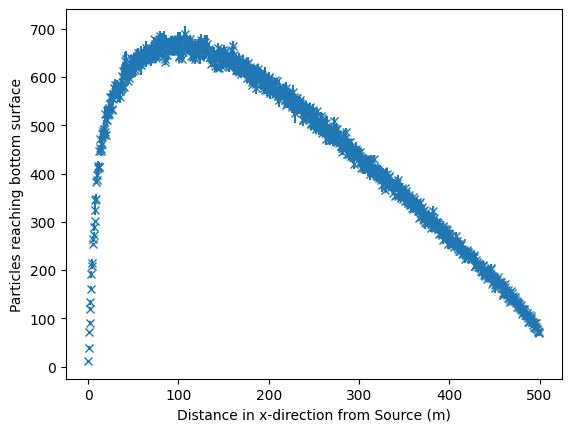

In [119]:
norm_curr_mean = 1e6 * curr_mean
norm_curr_std = 1e6 * curr_std
plt.errorbar(distance_x[:-1]/100, norm_curr_mean, norm_curr_std, ls='None', marker='x')
plt.xlabel("Distance in x-direction from Source (m)")
plt.ylabel("Particles reaching bottom surface")

In [120]:
#total
total = norm_curr_mean.cumsum().iloc[-1]
total

448722.92749028595

In [121]:
percent_reach_bott = total/(1e6)#


print("The percentage of particles reaching the bottom mesh surface is " + str(percent_reach_bott*100) + " %")

The percentage of particles reaching the bottom mesh surface is 44.872292749028595 %
